# Analyse des données Twitter

La stratégie suit généralement des étapes similaires :

- récupération des données
- nettoyage et consolidation des données (data management)
- construction des réseaux
- explorations, visualisations et statistiques

Par contre la question principale est  : qu'est-ce que l'on veut étudier ? 

- un phénomène spécifique sur la plateforme : morphologie, évolution, etc.
- des dynamiques (corrélations entre certains comportements et éléments)
- d'autres phénomènes en prenant les interactions comme proxy : attitudes


## 1. Collecter les données

In this case, I use `twarc` with commandline. Others options exist, for instance as a librairy.

To use `twarc` : https://twarc-project.readthedocs.io/en/latest/twarc2_en_us/

## 2 - Consolider les données

Pour l'exploration, utilisons `Pandas`

In [1]:
import pandas as pd

Chargeons les données

In [2]:
data = pd.read_csv("../../../../../Téléchargements/tweets_aiORartificial_FULL.csv", 
                    low_memory=False)
data.shape

(208386, 83)

In [3]:
data.head()

,id,conversation_id,referenced_tweets.replied_to.id,referenced_tweets.retweeted.id,referenced_tweets.quoted.id,author_id,in_reply_to_user_id,in_reply_to_username,retweeted_user_id,retweeted_username,...,geo.geo.bbox,geo.geo.type,geo.id,geo.name,geo.place_id,geo.place_type,matching_rules,__twarc.retrieved_at,__twarc.url,__twarc.version
0,1621090140209938432,1621090140209938432,NaN,NaN,1.621032e+18,98652139,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-02-02T10:22:42+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.12.0
1,1621073114154270720,1621073114154270720,NaN,1.620031e+18,NaN,2602152509,NaN,NaN,1.045620e+18,V7Labs,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-02-02T10:22:42+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.12.0
2,1621056195254517762,1621056195254517762,NaN,NaN,NaN,499643239,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-02-02T10:22:42+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.12.0
3,1621024454204854272,1621024454204854272,NaN,1.620952e+18,NaN,290980590,NaN,NaN,1.844873e+07,james_goldfarb,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-02-02T10:22:42+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.12.0
4,1621024442632605697,1621024442632605697,NaN,1.620952e+18,NaN,290980590,NaN,NaN,3.402698e+09,DrDreMDPhD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-02-02T10:22:42+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.12.0


In [4]:
#data.columns

Filtrer uniquement les tweets originaux ?

In [4]:
filtre = pd.isnull(data["retweeted_user_id"]) & pd.isnull(data["quoted_user_id"]) 

In [6]:
filtre.sum()

69810

#### Evolution temporelle

In [7]:
data["date"] = pd.to_datetime(data['created_at'])
data["num"] = 1

Visualisation

<AxesSubplot:xlabel='date'>

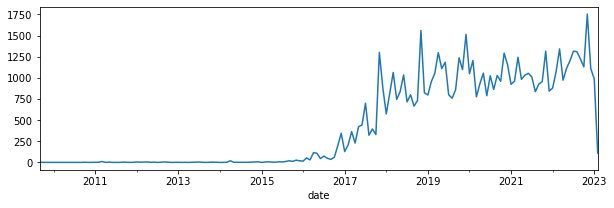

In [8]:
data[filtre].set_index("date")["num"].resample("m").sum().plot(figsize=(10,3))

Explorer les bursts ?

Regarder des tweets particuliers : une classe pour visualiser un tweet

In [9]:
import requests
class Tweet(object):
    """
    Object to visualize a specific tweet
    """
    def __init__(self, s):
        """
        s : id of a tweet
        """
        s = f"https://twitter.com/OReillyMedia/status/{s}"
        api = 'https://publish.twitter.com/oembed?url={}'.format(s)
        response = requests.get(api)
        self.text = response.json()["html"]

    def _repr_html_(self):
        return self.text

In [10]:
Tweet(data.iloc[1001]["id"])

#### La langue des tweets

In [11]:
data['lang'].value_counts().head()

en     200966
fr       1485
es       1295
qme       692
und       521
Name: lang, dtype: int64

We can check it is a French thing : https://trends.google.com/trends/explore?q=lancetgate

Uniquement les tweets français

In [12]:
data = data[data['lang']=="en"]

In [13]:
len(data)

200966

#### Les principaux comptes

In [15]:
data['author.username'].value_counts().head()

JohnLaprise        9860
Radiology_AI       4131
VonRosenchild      3814
libkey_io          3733
RadiologyGamuts    3490
Name: author.username, dtype: int64

Number of users

In [16]:
len(data['author.username'].unique())

37377

### Extract hashtags

Add a new column in the dataframe with the list of hashtags for each tweet

(in this case, the metadata are not very friendly)

In [17]:
import re # standard module for regular expression

def extract_hashtags(text):
    """
    function to extract hashtags in a text
    """
    return re.findall("(#\w+)", text.lower())

In [18]:
extract_hashtags("it is a sentence with an #hashtag")

['#hashtag']

In [19]:
data["hashtags"] = data['text'].str.lower().apply(extract_hashtags)

In [20]:
data["hashtags"]

0                            [#healthtech, #radiology, #ai]
1                                                        []
2         [#ai, #mri, #imaging, #radiology, #artificalin...
3                                              [#radaichat]
4                                              [#radaichat]
                                ...                        
208378                                                   []
208380                                                   []
208381                                                   []
208384                                                   []
208385                                                   []
Name: hashtags, Length: 200966, dtype: object

## Step 3 : Creating networks

The idea is to create networks to be analyzed in an other software

In [22]:
from itertools import combinations # create combinations of a set

#pip install network
import networkx as nx # library for network analysis in python

### Non directed retweet

I want to create a network with the properties :

- A node is created if a user tweet or retweet. If the user exist, I want to increase by one a parameter weight
- A link is created if a user retweet another one

To create the network

1. Create a graph empty
2. I make a loop on all the tweets
3. For each tweet, in create node/edge

In [23]:
# create an empty network
network_retweets = nx.Graph()

# A loop for each tweet of my dataset
for i, line in data.iterrows():
    
    # name of the user of the tweet
    user = str(line["author.username"])
    
    # is the user already in my network
    if not user in network_retweets.nodes:
        # if not, we add it with a weight of 1
        network_retweets.add_node(user, label=user, weight=1)
    else:
        # if yes, i only increase its weight
        network_retweets.nodes[user]["weight"] += 1    

    # if the tweet is a retweet
    if pd.notnull(line["retweeted_username"]):

        # the name of the user retweeted
        retweet_user = str(line["retweeted_username"])
        
        # if the retweeted user is not in the network
        if not retweet_user in network_retweets.nodes:
            # create a node
            network_retweets.add_node(retweet_user, label=retweet_user, weight=0)

        # if there is a retweet
        if pd.notnull(retweet_user):
            
            # if the edge between retweeted user and retweeting user not exist
            if not network_retweets.has_edge(user, retweet_user):
                # creating the edge
                network_retweets.add_edge(user, retweet_user, weight=1)
            else:
                # increasing its weight
                network_retweets[user][retweet_user]["weight"] += 1 

In [24]:
len(network_retweets.edges)

58763

In [25]:
len(network_retweets.nodes)

37471

Export it as a file we can open on Gephi

In [55]:
nx.write_graphml(network_retweets,"./graph_retweets_lancetgate.graphml")

In [26]:
from ipysigma import Sigma

In [27]:
nodes_ss =  [i for i in network_retweets.nodes if network_retweets.nodes[i]["weight"]>10]

In [28]:
Sigma(network_retweets.subgraph(nodes_ss),node_size="weight")

Sigma(nx.Graph with 1,993 nodes and 18,908 edges)

### hashtags

- 1-mode network
- 2 hashtags connected if mentionned in the same tweet

In [29]:
# empty network
network_hashtags = nx.Graph()

# every tweets
for i, line in data.iterrows():
    
    # adding the nodes
    for e in line["hashtags"]:
        if not e in network_hashtags.nodes:
            network_hashtags.add_node(e, label=e, weight=1)
        else:
            network_hashtags.nodes[e]["weight"] += 1
    
    # adding the edges (all combinations)
    for i, j in combinations(line["hashtags"], 2): 
        if not network_hashtags.has_edge(i, j):
            network_hashtags.add_edge(i, j, weight=1)
        else:
            network_hashtags[i][j]["weight"] += 1

In [30]:
print(len(network_hashtags))

11417


In [31]:
len(network_hashtags.edges)

101045

In [59]:
nx.write_graphml(network_hashtags,"./graph_hashtags_lancetgate.graphml")

In [34]:
nodes_ss =  [i for i in network_hashtags.nodes if network_hashtags.nodes[i]["weight"]>10]

In [35]:
Sigma(network_hashtags.subgraph(nodes_ss),node_size="weight")

Sigma(nx.Graph with 2,380 nodes and 47,796 edges)